In [313]:
%matplotlib inline

In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob

import sklearn.model_selection as model
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
#used TfidfVectorizer over CV because the regression analysis didn't converge in the latter.

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report

sns.set_palette("YlGnBu")
sns.set(rc={'figure.figsize':(12,9)})

## Importing data


In [315]:
required_df = pd.read_csv("Information.csv", engine = 'python')

In [316]:
required_df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade
3,815719229,False,finalized,3,10/26/15 23:10,male,1.0000,yes,1.0,6/11/09 22:39,...,https://pbs.twimg.com/profile_images/259703936...,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,NaN,1693,10/26/15 12:40,6.587300e+17,"Palo Alto, CA",Pacific Time (US & Canada)
4,815719230,False,finalized,3,10/27/15 1:15,female,1.0000,yes,1.0,4/16/14 13:23,...,https://pbs.twimg.com/profile_images/564094871...,0,0,Watching Neighbours on Sky+ catching up with t...,NaN,31462,10/26/15 12:40,6.587300e+17,NaN,NaN


In [317]:
required_df.shape

(20050, 26)

In [318]:
required_df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

<p> <b> Formating Column Names </b> </p>

In [319]:
required_df.columns = required_df.columns.str.strip().str.replace('_', ' ')
required_df.columns

Index([' unit id', ' golden', ' unit state', ' trusted judgments',
       ' last judgment at', 'gender', 'gender:confidence', 'profile yn',
       'profile yn:confidence', 'created', 'description', 'fav number',
       'gender gold', 'link color', 'name', 'profile yn gold', 'profileimage',
       'retweet count', 'sidebar color', 'text', 'tweet coord', 'tweet count',
       'tweet created', 'tweet id', 'tweet location', 'user timezone'],
      dtype='object')

In [320]:
required_df.columns = required_df.columns.str.strip().str.replace(' ', '_')
required_df.columns

Index(['unit_id', 'golden', 'unit_state', 'trusted_judgments',
       'last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

### Understanding the different values in certain columns 

In [321]:
columns = ['golden','unit_state','gender','profile_yn','gender_gold','profile_yn_gold','trusted_judgments']

unique_values = {}
for x in columns:
    unique_values[x] = required_df[x].unique()

print(unique_values)


{'golden': array([False,  True]), 'unit_state': array(['finalized', 'golden'], dtype=object), 'gender': array(['male', 'female', 'brand', 'unknown', nan], dtype=object), 'profile_yn': array(['yes', 'no'], dtype=object), 'gender_gold': array([nan, 'male', 'brand', 'female', 'female\nunknown', 'male\nunknown',
       'unknown'], dtype=object), 'profile_yn_gold': array([nan, 'yes'], dtype=object), 'trusted_judgments': array([  3, 249, 271, 245, 261, 247, 242, 256, 262, 259, 264, 258, 260,
       228, 233, 255, 235, 254, 231, 274, 246, 273, 239, 270, 237, 227,
       253, 252, 212, 240, 248, 250], dtype=int64)}


## We can observe nans in this dataset. These observations will be dropped.

In [322]:
required_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
unit_id                  20050 non-null int64
golden                   20050 non-null bool
unit_state               20050 non-null object
trusted_judgments        20050 non-null int64
last_judgment_at         20000 non-null object
gender                   19953 non-null object
gender:confidence        20024 non-null float64
profile_yn               20050 non-null object
profile_yn:confidence    20050 non-null float64
created                  20050 non-null object
description              16306 non-null object
fav_number               20050 non-null int64
gender_gold              50 non-null object
link_color               20050 non-null object
name                     20050 non-null object
profile_yn_gold          50 non-null object
profileimage             20050 non-null object
retweet_count            20050 non-null int64
sidebar_color            20050 non-null object
text    

#### Columns containing null values are gender, gender:confidence, description, gender_gold, profile_yn_gold, tweet_coord, tweet_location, user_timezone

In [323]:
required_df.isnull().sum()

unit_id                      0
golden                       0
unit_state                   0
trusted_judgments            0
last_judgment_at            50
gender                      97
gender:confidence           26
profile_yn                   0
profile_yn:confidence        0
created                      0
description               3744
fav_number                   0
gender_gold              20000
link_color                   0
name                         0
profile_yn_gold          20000
profileimage                 0
retweet_count                0
sidebar_color                0
text                         0
tweet_coord              19891
tweet_count                  0
tweet_created                0
tweet_id                     0
tweet_location            7484
user_timezone             7798
dtype: int64

### Dropping columns that we will not be using 

In [324]:
required_df = required_df.drop(columns = ['gender_gold','profile_yn_gold','tweet_coord','user_timezone','last_judgment_at','unit_state','profile_yn','profile_yn:confidence','trusted_judgments','profileimage','tweet_location','tweet_created','tweet_id'])
required_df.isnull().sum()



unit_id                 0
golden                  0
gender                 97
gender:confidence      26
created                 0
description          3744
fav_number              0
link_color              0
name                    0
retweet_count           0
sidebar_color           0
text                    0
tweet_count             0
dtype: int64

### Dropping null values 

In [325]:
required_df.dropna(inplace = True)
required_df.shape

(16224, 13)

In [326]:
required_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16224 entries, 0 to 20049
Data columns (total 13 columns):
unit_id              16224 non-null int64
golden               16224 non-null bool
gender               16224 non-null object
gender:confidence    16224 non-null float64
created              16224 non-null object
description          16224 non-null object
fav_number           16224 non-null int64
link_color           16224 non-null object
name                 16224 non-null object
retweet_count        16224 non-null int64
sidebar_color        16224 non-null object
text                 16224 non-null object
tweet_count          16224 non-null int64
dtypes: bool(1), float64(1), int64(4), object(7)
memory usage: 1.6+ MB


### Are there any duplicate entires in this dataset ?

In [327]:
required_df.duplicated().sum()

0

### No.

### Removing entries whose gender is unknown

In [328]:
required_df = required_df[required_df.gender != 'unknown']

### Eliminating users that were not 100% confident about their gender. 

In [329]:
required_df = required_df[required_df["gender:confidence"] == 1]
required_df.shape

(11773, 13)

#### We no longer need gender:confidence 

In [330]:
required_df.drop(columns = ['gender:confidence'], inplace = True)

### Typecasting description, text and name to String.

In [331]:
string_cols = ['description','text','name']

for y in string_cols:
    required_df[y] = required_df[y].astype(str)
   
    
required_df.head()

,unit_id,golden,gender,created,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count
0,815719226,False,male,12/5/13 1:48,i sing my own rhythm.,0,08C2C2,sheezy0,0,FFFFFF,Robbie E Responds To Critics After Win Against...,110964
1,815719227,False,male,10/1/12 13:51,I'm the author of novels filled with family dr...,68,0084B4,DavdBurnett,0,C0DEED,‰ÛÏIt felt like they were my friends and I was...,7471
3,815719229,False,male,6/11/09 22:39,"Mobile guy. 49ers, Shazam, Google, Kleiner Pe...",202,0084B4,douggarland,0,C0DEED,Hi @JordanSpieth - Looking at the url - do you...,1693
4,815719230,False,female,4/16/14 13:23,Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...,37318,3B94D9,WilfordGemma,0,0,Watching Neighbours on Sky+ catching up with t...,31462
5,815719231,False,female,3/11/10 18:14,you don't know me.,3901,F5ABB5,monroevicious,0,0,"Ive seen people on the train with lamps, chair...",20036


### Removing special characters, url tags, multiple spaces

In [332]:
def cleaning(st):
    st = st.lower()
    st = re.sub('\s\W',' ',st)
    st = re.sub('\W\s',' ',st)
    st = re.sub(r'[^\w]',' ', st)
    st = re.sub("\d+","", st)
    st = re.sub('\s+',' ',st)
    st = re.sub('[!@#$_]','', st)
    st = st.replace("co","")
    st = st.replace("https","")
    st = st.replace(",","")
    st = st.replace("[\w*"," ")
    return st

required_df['text'] = [cleaning(content) for content in required_df['text']]
required_df['description'] = [cleaning(content) for content in required_df['description']]
required_df['name'] = [cleaning(content) for content in required_df['name']]

### Removing Stopwords

In [333]:
stop = stopwords.words('english')

for y in ['description','text']:
    required_df[y] = required_df[y].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Lematization

In [334]:
lm = WordNetLemmatizer()

for y in ['description','text']:
    required_df[y] = required_df[y].apply(lambda x: " ".join([lm.lemmatize(word) for word in x.split()]))

## Exploratory Data Analysis

###  Q2.)Which day attracted new users the most ? 

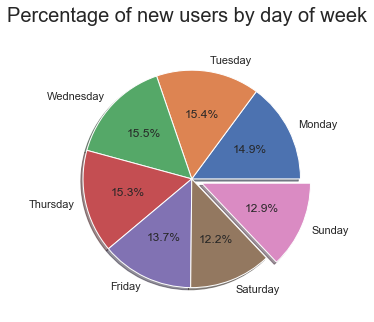

In [335]:
# converting created to datetime 
required_df['created'] = pd.to_datetime(required_df['created'])

# obtaining the weekday from created column
required_df['weekday'] = required_df['created'].dt.day_name()

# counting the number of accounts that were created on each day of the week
accounts_day = required_df.groupby("weekday")["unit_id"].nunique()


days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday']
new_users_per_day = []
for x in days:
    new_users_per_day.append(accounts_day[x])

# creating a pie chart
labels = days
sizes = new_users_per_day
explode =  (0, 0, 0, 0, 0, 0, 0.1) 
plt.figure(figsize=(5,5))
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = True,explode = explode)
plt.suptitle('Percentage of new users by day of week', fontsize=20)
plt.show()

Least number of users were created on Saturdays while the platform seemed to welcome most users on Wednesday. 

###  Q3.) Twitter users with the highest tweet_ count and the highest re-tweet count?


### Tweet with the highest re-tweet count

In [336]:
y = required_df['retweet_count'].max()

highest_retweet = required_df[required_df['retweet_count'] == y]
highest_retweet

,unit_id,golden,gender,created,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count,weekday
8810,815728145,False,male,2009-10-12 05:03:00,part time rapper full time vlogger kale king p...,13740,9999,marcusbutler,153,FFFFFF,lady gentleman meet new prime minister joke to...,14085,Monday


#### A:- The user with the highest re-tweet count was "MarcusButler", a male candidate with a score of 153. 	 

### Tweet with the highest tweet_count

In [337]:
x = required_df['tweet_count'].max()

highest_tweet = required_df[required_df['tweet_count'] == x]
highest_tweet

,unit_id,golden,gender,created,description,fav_number,link_color,name,retweet_count,sidebar_color,text,tweet_count,weekday
15940,815735441,False,male,2012-02-21 18:17:00,nfira ultima notìcias que estìá antecendo bras...,81372,FFCC4D,gabrieldsmqs,0,0,one state ûªs struggle make end meet illinois ...,2680199,Tuesday


#### A:- The user with the highest tweet count was "Mr. Gabriel dsmqs", a male candidate with a score of 2680199. 

### Number of users that were considered in the golden standard 

In [338]:
no_of_golden = required_df[required_df['golden'] == True]
len(no_of_golden)

27

<p> Only 27 users were considered in the golden standard for the model. Since this is a small number, it will be not be considered in our training models later. This column will be dropped later as well. </p>

Let's see if there's gender bias here or not

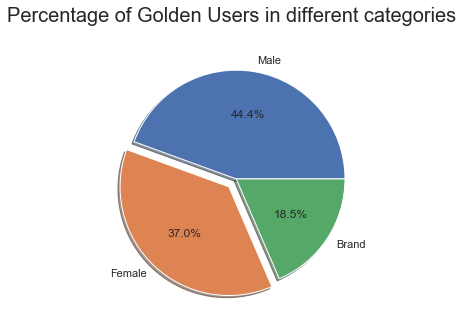

2

In [339]:
# no. of males
male_golden = no_of_golden[no_of_golden['gender'] == 'male']
m = len(male_golden)

# no. of females
female_golden = no_of_golden[no_of_golden['gender'] == 'female']
n = len(female_golden)

# no. of brands
brand_count = len(no_of_golden) - m - n

#creating a pie chart
genders = ['Male','Female','Brand']
labels = genders
sizes = [m, n,brand_count]
explode = (0,0.1,0)
plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True,explode = explode)
plt.suptitle('Percentage of Golden Users in different categories', fontsize=20)
plt.show()
m - n

The number of Male-Golden-Users exceeds that of female users by 2.

In [340]:
#dropping golden column
required_df = required_df.drop('golden', axis = 1)

### Bar plot for  Gender Column

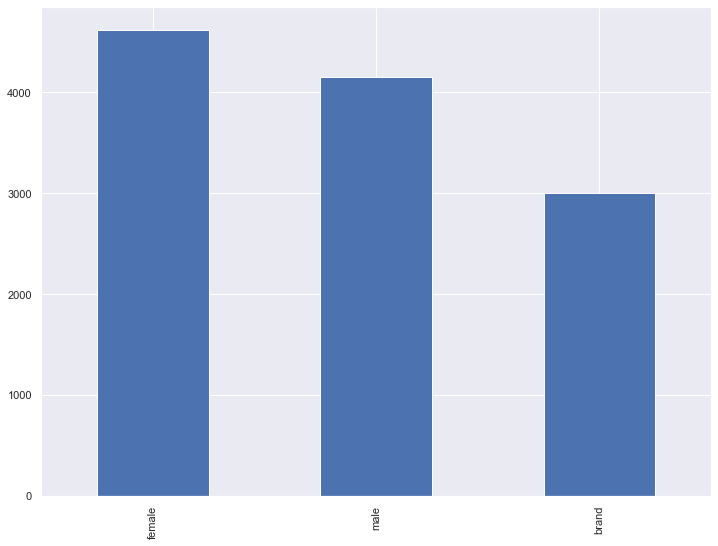

In [341]:
required_df['gender'].value_counts().plot(kind='bar')

In [342]:
# helper function to display a cloud plot
def cloud_plot(wordcloud,title):
    fig = plt.figure(1, figsize=(20,15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title, fontsize = 30)
    plt.show()

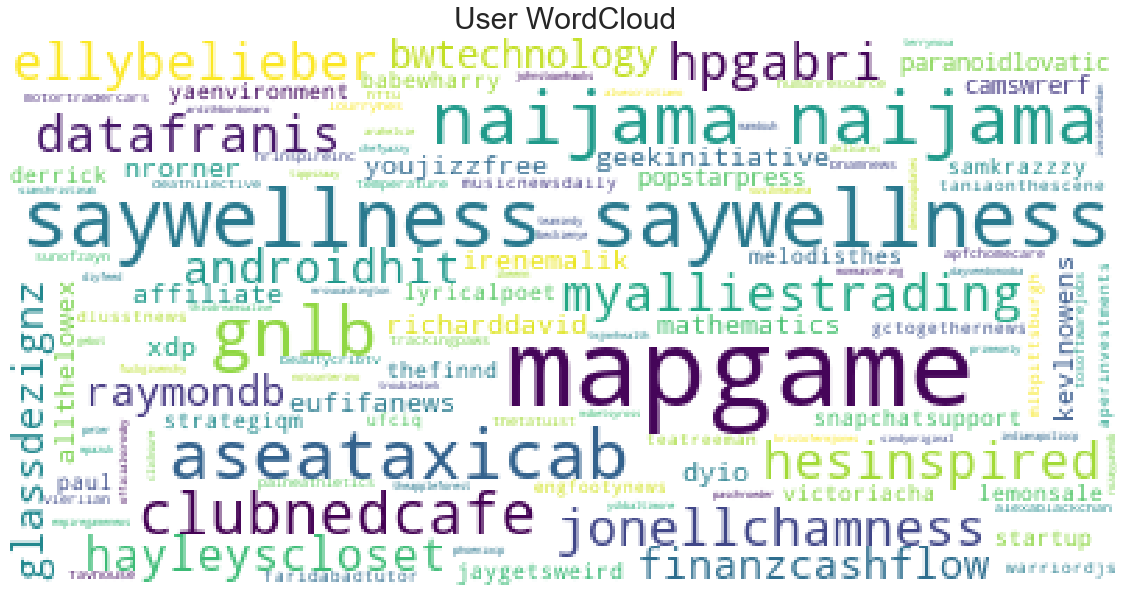

In [343]:
# cloud plot for user names
desc_wordcloud = WordCloud(background_color = 'white' ,stopwords=set(STOPWORDS), max_words=150, max_font_size=40, random_state=1300).generate(' '.join(required_df['name']))
cloud_plot(desc_wordcloud,'User WordCloud')

### Q1.)Most common words used by males and females in their tweets?

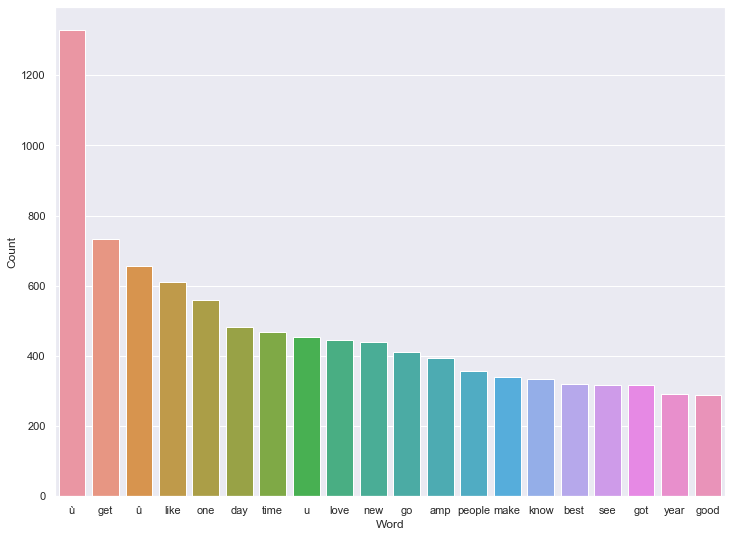

In [344]:
# tokenizing male tweets
male_tweets = required_df[required_df['gender'] == 'male']
tokenized_mt = nltk.word_tokenize(' '.join(male_tweets['text']))

# tokenizing female tweets
female_tweets = required_df[required_df['gender'] == 'female']
tokenized_ft = nltk.word_tokenize(' '.join(female_tweets['text']))

# list of common words
common_words = list(set(tokenized_ft).intersection(set(tokenized_mt)))

# tokenizing all the tweets
all_tweets = required_df['text']
tokenized_tweets = nltk.word_tokenize(' '.join(all_tweets))

# creating a dataframe that shows the number of times each word has occurred 
count_words = FreqDist(tokenized_tweets)
counts_df = pd.DataFrame(count_words.items(), columns=['Word', 'Count'])

# slicing counts_df for common_words and sorting it in descending order
common_words_with_freq = counts_df[counts_df['Word'].isin(common_words)].sort_values(by = ['Count'], ascending = False)

# slicing the top 20 words
top_twenty_common = common_words_with_freq[:20]

# boxplot to depict 
ax = sns.barplot(x="Word", y="Count", data= top_twenty_common)

#### A:- Most common words used by male and female are: {get,like,one,day,time,u,love,new,go,amp,people,make,know,best,see,got,year,good}

In [345]:
len(common_words)

4259

## Feature Engineering 

In [346]:
cv1 = TfidfVectorizer(max_features = 20000)
X_text = cv1.fit_transform(required_df['text'])
words = cv1.get_feature_names()
len(words)

20000

In [347]:
cv2 = TfidfVectorizer(max_features = 20000)
X_description = cv2.fit_transform(required_df['description'])
words2 = cv2.get_feature_names()
len(words2)

20000

# Ensemble Machine Learning Modelling 

## Label Encoding

In [348]:
encoder = LabelEncoder()
y = encoder.fit_transform(required_df['gender'])
name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(name_mapping)

{'brand': 0, 'female': 1, 'male': 2}


## Consider text :

In [349]:
X = X_text
X_train, X_test, Y_train, Y_test = train_test_split(X,y,random_state=42, stratify = y)
print ('Train set:', X_train.shape, Y_train.shape)
print ('Test set:', X_test.shape, Y_test.shape)

Train set: (8829, 20000) (8829,)
Test set: (2944, 20000) (2944,)


### 1) Naive Bayes Classifiaction Algorithm

In [350]:
nb = MultinomialNB()
nb.fit(X_train, Y_train)
nb_pred = nb.predict(X_test)

### 2) Logistic Regression Algorithm

In [351]:
logReg = LogisticRegression()
logReg.fit(X_train, Y_train)
logreg_pred = logReg.predict(X_test)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### 3) Random Forest Classifier

In [352]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train,Y_train)
rf_pred = rf.predict(X_test)

## Consider description :

## Train / Test /Split

In [353]:
X = X_description
X_train_d, X_test_d, Y_train_d, Y_test_d = train_test_split(X,y,random_state=42, stratify = y)
print ('Train set:', X_train_d.shape, Y_train_d.shape)
print ('Test set:', X_test_d.shape, Y_test_d.shape)

Train set: (8829, 20000) (8829,)
Test set: (2944, 20000) (2944,)


### 1) Naive Bayes Classifiaction Algorithm

In [354]:
nb = MultinomialNB()
nb.fit(X_train_d, Y_train_d)
nb_pred_d = nb.predict(X_test_d)

### 2) Logistic Regression Algorithm

In [355]:
logReg = LogisticRegression()
logReg.fit(X_train_d, Y_train_d)
logreg_pred_d = logReg.predict(X_test_d)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### 3) Random Forest Classifier

In [356]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train_d,Y_train_d)
rf_pred_d = rf.predict(X_test_d)

## Comparing the differenet classifiers used and the features to predict gender

### With text :-

In [358]:

logreg_accuracyscore = accuracy_score(logreg_pred, Y_test)
print("Logistic Regression accuracy score: ",logreg_accuracyscore)
print(classification_report(Y_test,logreg_pred))

Logistic Regression accuracy score:  0.5244565217391305
              precision    recall  f1-score   support

           0       0.63      0.47      0.53       752
           1       0.53      0.64      0.58      1154
           2       0.46      0.44      0.45      1038

    accuracy                           0.52      2944
   macro avg       0.54      0.51      0.52      2944
weighted avg       0.53      0.52      0.52      2944



#### Accuracy= 0.5190217391304348 = 51.90%

In [357]:
nb_accuracyscore = accuracy_score(nb_pred, Y_test)
print("Naive Bayes Algo accuracy score: ",nb_accuracyscore,)
print(classification_report(Y_test,nb_pred))

Naive Bayes Algo accuracy score:  0.5190217391304348
              precision    recall  f1-score   support

           0       0.76      0.32      0.45       752
           1       0.50      0.79      0.61      1154
           2       0.47      0.36      0.41      1038

    accuracy                           0.52      2944
   macro avg       0.57      0.49      0.49      2944
weighted avg       0.55      0.52      0.50      2944



#### Accuracy= 0.5244565217391305 = 52.44%

In [359]:

rf_accuracyscore = accuracy_score(rf_pred, Y_test)
print("Random Forest accuracy score: ",rf_accuracyscore)
print(classification_report(Y_test,rf_pred))

Random Forest accuracy score:  0.49014945652173914
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       752
           1       0.50      0.58      0.53      1154
           2       0.43      0.44      0.44      1038

    accuracy                           0.49      2944
   macro avg       0.51      0.48      0.49      2944
weighted avg       0.50      0.49      0.49      2944



#### Accuracy= 0.49014945652173914 = 49.01%

### With description :-

In [360]:
nb_accuracyscore = accuracy_score(nb_pred_d, Y_test_d)
print("Naive Bayes Algo accuracy score: ",nb_accuracyscore)
print(classification_report(Y_test_d,nb_pred_d))

Naive Bayes Algo accuracy score:  0.6708559782608695
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       752
           1       0.61      0.78      0.69      1154
           2       0.63      0.52      0.57      1038

    accuracy                           0.67      2944
   macro avg       0.70      0.67      0.68      2944
weighted avg       0.68      0.67      0.67      2944



#### Accuracy = 0.6708559782608695 = 67.085%

In [361]:

logreg_accuracyscore = accuracy_score(logreg_pred_d, Y_test_d)
print("Logistic Regression accuracy score: ",logreg_accuracyscore)
print(classification_report(Y_test_d,logreg_pred_d))

Logistic Regression accuracy score:  0.6531929347826086
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       752
           1       0.60      0.78      0.67      1154
           2       0.63      0.50      0.55      1038

    accuracy                           0.65      2944
   macro avg       0.68      0.65      0.66      2944
weighted avg       0.67      0.65      0.65      2944



#### Accuracy= 0.6531929347826086 = 65.319%

In [362]:

rf_accuracyscore = accuracy_score(rf_pred_d, Y_test_d)
print("Random Forest accuracy score: ",rf_accuracyscore)
print(classification_report(Y_test_d,rf_pred_d))

Random Forest accuracy score:  0.6304347826086957
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       752
           1       0.57      0.78      0.66      1154
           2       0.62      0.40      0.49      1038

    accuracy                           0.63      2944
   macro avg       0.66      0.63      0.63      2944
weighted avg       0.64      0.63      0.62      2944



#### Accuracy= 0.6304347826086957 = 63.043%